## <a id='toc1_1_'></a>[SLV Model calibration using particle method](#toc0_)

This project aims at calibrating <i>Stochastic Local Volatility (SLV)</i> Model.

**Table of contents**<a id='toc0_'></a>    
- [SLV Model calibration using particle method](#toc1_1_)    
    - [Stochastic Volatility (SV), Local Volatility (LV) and Stochastic Local Volatility (SLV)](#toc1_1_1_)    
      - [LV calibration](#toc1_1_1_1_)    
      - [SV calibration condition](#toc1_1_1_2_)    
      - [SLV calibration](#toc1_1_1_3_)    
      - [Particle method to calibrate SLV Model](#toc1_1_1_4_)    
    - [Implementation](#toc1_1_2_)    
      - [Nadaraya-Watson (NW) regression](#toc1_1_2_1_)    
      - [SLV calibration](#toc1_1_2_2_)    
      - [Parameters impact](#toc1_1_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Stochastic Volatility (SV), Local Volatility (LV) and Stochastic Local Volatility (SLV)](#toc0_)

SLV Model is an extension of the <i>Stochastic Volatility (SV)</i> Model and the <i>Local Volatility (LV)</i> Model. We will consider both models with constant risk-free rate and no dividend.<br>
LV model is defined by (under risk-neutral probability $\mathbb{Q}$, in which $W = (W_t)_{t\geq 0}$ is a Brownian Motion and $r$ is the risk-free rate):
$$
    \dfrac{dS_t}{S_t} = rdt + \sigma (t, S_t)dW_t \tag{SV}
$$
SV model is defined by:
\begin{align*}
    &\dfrac{dS_t}{S_t} = rdt + \sqrt{V_t} dW_t^S\\
    &dV_t = \kappa(\theta - V_t)dt + \omega \sqrt{V_t}dW_t^V\\
    &d\langle W^S, W^V \rangle_t = \rho dt
\end{align*}
where $\rho$ is the instantaneous correlation between the two Brownian Motions.<br>

#### <a id='toc1_1_1_1_'></a>[LV calibration](#toc0_)
Let q be the instantaneous dividend rate. LV model can be calibrated to the market using Dupire's formula. For a maturity $T$, a Call price $C$ and a spot level $K$, we have:
$$
\sigma^2(T,K) = \dfrac{\partial_T C_{Mkt}(T,K) + (r-q)K \partial_K C_{Mkt}(T,K) + q C_{Mkt}(T,K)}{\frac{1}{2}K^2 \partial_K^2C_{Mkt}(T,K)}
$$
<b><u>N.B :</u></b> $C_{Mkt}(T,K)$ is the market call price for maturity T and strike K.<br>
So if we have market Call prices, we can use this formula to get values of the local volatility function. To get any value of the function, we perform cubic spline interpolations and extrapolations along tenor and strike prices.

#### <a id='toc1_1_1_2_'></a>[SV calibration condition](#toc0_)
SV calibration condition comes from Gyöngy's theorem (1986).<br>
<br>
<b>Gyöngy's theorem :</b><br>
If we have the following non markovian SDE :
$$
    \dfrac{dS_t}{S_t} = \mu_t dt + \sigma_t dW_t
$$
and we define :
\begin{align*}
    &\sigma^2(t,S) = \mathbb{E}^{\mathbb{Q}}[\sigma_t^2 \, | \, S_t = S]\\
    &\mu(t,S) = \mathbb{E}^{\mathbb{Q}}[\mu_t \, | \, S_t = S]
\end{align*}
Then we have :
$$
    \dfrac{d\overline{S}_t}{\overline{S}_t} = b(t, \overline{S}_t)dt + \sigma(t,\overline{S}_t)dW_t
$$
Then for all $t\geq 0$, the law of $S_t$ is the same as $\overline{S}_t$, i.e. : $\mathcal{L}(S_t) = \mathcal{L}(\overline{S}_t)$.<br>
<br>
Using this result, we have the following condition to calibrate this model to market data :
$$
    \sigma^2(t,S) = \mathbb{E}^{\mathbb{Q}}[\sigma_t^2 \, | \, S_t = S]
$$
where $\sigma(t,S)$ can be computed using Dupire's formula, for all $t\geq 0$ and spot level $S$. This mathematical relationship between SV and LV models will be used in SLV model calibration.

#### <a id='toc1_1_1_3_'></a>[SLV calibration](#toc0_)

We take a SLV model of the form:
\begin{align*}
    &\dfrac{dS_t}{S_t} = a_t l(t,S_t)dW_t^1\\
    &a_t = a_0e^{Y_t}\\
    &dY_t = -\kappa Y_t dt + \gamma dW_t^2\\
    &d\langle W^1, W^2 \rangle_t = \rho dt
\end{align*}
where $a$ is the stochastic volatility part and $l$ the local volatility part (also called leverage function).<br>
It is easy to solve the SDE of $Y$ with Ito's formula. The explicit solution is:
$$
    Y_t = Y_0e^{-\kappa t} + \int_0^t \gamma e^{-\kappa (t-s)}dW_s^2
$$
giving the following discrete scheme (taking a time step of $\Delta t_i$):
$$
    Y_{t_i} = Y_{t_{i-1}}e^{-\kappa \Delta t_i} + \int_{t_{i-1}}^{t_i} \gamma e^{-\kappa(t_i - s)}dW_s^2
$$
Obviously $Y_{t_i} | Y_{t_{i-1}}$ is gaussian, and
\begin{align*}
    &\mathbb{E}^{\mathbb{Q}}[Y_{t_i} | Y_{t_{i-1}}] = Y_{t_{i-1}}e^{-\kappa \Delta t_i}, \; \text{(because } \int_{t_{i-1}}^{t_i} \gamma e^{-\kappa(t_i - s)}dW_s^2 \text{ is a martingale)}\\
    & Var^{\mathbb{Q}}[Y_{t_i} | Y_{t_{i-1}}] = \int_{t_{i-1}}^{t_i} \gamma^2 e^{-2\kappa(t_i - s)}ds = \dfrac{\gamma^2}{2\kappa}(1 - e^{-2\kappa \Delta t_i})
\end{align*}
<br>
Applying Ito's formula on $\log(S_t)$, we get:
$$
    d \log(S_t) = a_t l(t,S_t)dW_t^1 - \dfrac{1}{2}a_t^2 l(t,S_t)^2dt
$$
and we deduce Euler scheme for the log spot:
$$
    \log(S_{t_i})-\log(S_{t_{i-1}}) = \sigma_0e^{Y_{t_{i-1}}}l(t_{i-1}, S_{t_{i-1}})(W_{t_i}^1 - W_{t_{i-1}}^1) - \dfrac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1}, S_{t_{i-1}})^2 \Delta t_i
$$
Thus, given $S_{t_{i-1}}, Y_{t_{i-1}}$, we have:
\begin{align*}
    &Var(\log S_{t_i} \, | \, S_{t_{i-1}}, Y_{t_{i-1}}) = \sigma_0^2 e^{2Y_{t_{i-1}}}l(t_{t_{i-1}}, S_{t_{i-1}})^2 \Delta t_i\\
    &Cov(Y_{t_i}, \log S_{t_i} \, | \, S_{t_{i-1}}, Y_{t_{i-1}}) = \dfrac{\gamma \rho}{\kappa}(1-e^{-\kappa \Delta t_i})\sigma_0 l(t_{i-1}, S_{t_{i-1}})e^{Y_{t_{i-1}}}\\
    \implies & \overline{\rho} := Corr(Y_{t_i}, \log S_{t_i} \, | \, S_{t_{i-1}}, Y_{t_{i-1}}) = \rho \sqrt{\dfrac{2(1 - e^{-\kappa \Delta t_i})}{\kappa \Delta t_i (1 + e^{-\kappa \Delta t_i})}}
\end{align*}
Hence, we can simulate $\log S_{t_i}, Y_{t_i}$:
\begin{align*}
    & \log S_{t_i} = \log S_{t_{i-1}} + \sigma_0e^{Y_{t_{i-1}}}l(t_{i-1}, S_{t_{i-1}})\sqrt{\Delta t_i}\left(\sqrt{1 - \overline{\rho}^2}X_1 + \overline{\rho} X_2 \right) - \dfrac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{t_{i-1}}, S_{t_{i-1}})^2 \Delta t_i\\
    & Y_{t_i} = e^{-\kappa \Delta t_i}Y_{t_{i-1}} + \gamma \sqrt{\dfrac{1 - e^{-2\kappa \Delta t_i}}{2\kappa}}X_2
\end{align*}
wher $X_1,X_2$ are two independent standard gaussian variables.


#### <a id='toc1_1_1_4_'></a>[Particle method to calibrate SLV Model](#toc0_)

In the SLV, the calibration condition is
\begin{align*}
    &l(t,S)^2\mathbb{E}^{\mathbb{Q}}[a_t^2 \, | \, S_t=S] = \sigma_{Market}(t, S)^2\\
    \implies & l(t,S)^2 = \dfrac{\sigma_{Market}(t, S)^2}{\mathbb{E}^{\mathbb{Q}}[a_t^2 \, | \, S_t=S]}\\
    &= \sigma_{Market}(t, S)^2\dfrac{\int p(t,S,a)da}{\int a^2p(t,S,a)da}
\end{align*}
Here, the solution includes the joint law of $S_t$ and $a_t$, with PDF $p$. Thus there are interactions between $S$ and $a$. If we write $X_t=(S_t,a_t)$, it follows a McKean SDE:
$$
    dX_t = \mu(t,X_t,\mathbb{P}_t)dt + \sigma(t,X_t,\mathbb{P}_t)dW_t
$$
with $\mathbb{P}_t = \mathcal{L}(X_t)$. To estimate $\mathbb{P}_t$ on $N$ points, we use the following empirical estimator:
$$
    \mathbb{P_t}^N = \dfrac{1}{N}\sum_{i=1}^N\delta_{i,N}
$$
where $\delta_{i,N}$ is the dirac mass on the $i$-th point. Instead of dirac mass, we will use Kernel with bandwidth (Nadaraya-Watson regression):
$$
    \mathbb{E}^{\mathbb{P}_t^N}(a_t^2 \, | \, S_t = S) = \dfrac{\sum_{i=1}^N(a_t^{i,N})^2K_h(S_t^{i,N}-S)}{\sum_{i=1}^NK_h(S_t^{i,N}-S)}
$$
where $K_h(x) = \dfrac{K(x/h)}{h}$, $h$ the bandwidth of the regression.

### <a id='toc1_1_2_'></a>[Implementation](#toc0_)

In [280]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.RankWarning)

from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm

#### <a id='toc1_1_2_1_'></a>[Nadaraya-Watson (NW) regression](#toc0_)
Here is a small example on how NW regression can approximate conditional expectation. Suppose that we have $X\sim \mathcal{N}(0,1)$ and $Y = g(X) + \epsilon$, where $g$ is a deterministic function on $\mathbb{R}$ and $\epsilon \sim \mathcal{N}(0,1/20)$ independent of $X$.<br>
We define $g$ by:
$$
    \forall \, x \in \mathbb{R}, \, g(x) = xe^{-x^2}
$$
Then, $\mathbb{E}(Y \, | \, X) = g(X) + \mathbb{E}(\epsilon \, | \, X) = g(X)$.

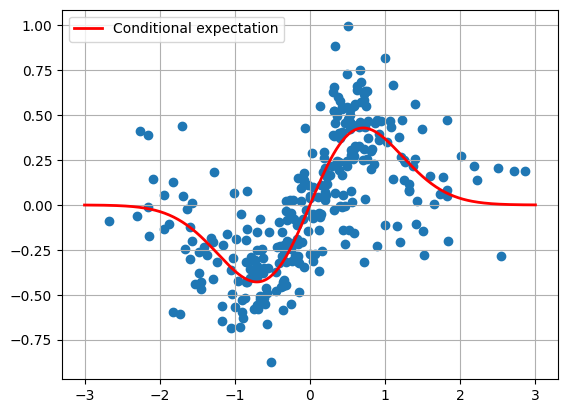

In [281]:
def g(x):
    return x*np.exp(-x**2)

N_pts = 300
X = np.random.normal(0, 1, N_pts)
Y = g(X) + np.sqrt(0.05)*np.random.normal(0, 1, N_pts)
x_pts = np.linspace(-3, 3, N_pts)

plt.scatter(X,Y)
plt.plot(x_pts, g(x_pts), color='red', lw=2, label="Conditional expectation")
plt.legend()
plt.grid()

For this example, we take a sample of $X$ on 95% of its distribution. For bandwidth size, we use silverman rule.

In [282]:
def gaussian_kernel(x):
    return np.exp(-x**2 / 2)

def quartic_kernel(x):
    x = np.clip(x, -1, 1)
    return (x + 1)**2 * (1 - x)**2

def cosine_kernel(x):
    x = np.clip(x, -1, 1)
    return np.cos(0.5 * np.pi * x)

def NW_regression(x, x_pts, y_pts, kernel, bandwidth):
    weights = kernel((x_pts[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * y_pts[:, np.newaxis], axis=0)/np.sum(weights, axis=0)

# Silverman's rule for bandwidth
bandw = np.std(X) * (4/(3*len(X)))**0.2
x_points = np.linspace(np.percentile(X, 2.5), np.percentile(X, 97.5), 30)

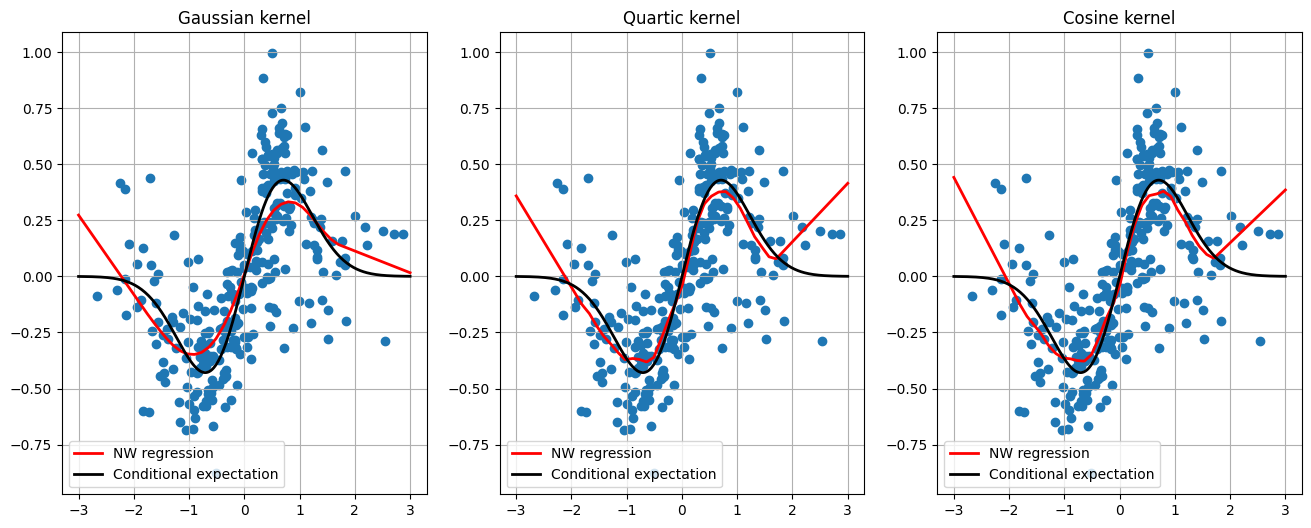

In [283]:
kernel = [gaussian_kernel, quartic_kernel, cosine_kernel]
titles = ['Gaussian', 'Quartic', 'Cosine']
fig, axs = plt.subplots(1,3)
fig.set_figwidth(16)
fig.set_figheight(6)
for idx, ax in enumerate(axs):
    y_points = NW_regression(x_points, X, Y, kernel[idx], bandw)
    p = interp1d(x_points, y_points, kind='linear', fill_value='extrapolate')

    ax.scatter(X, Y)
    ax.plot(x_pts, p(x_pts), color='red', lw=2, label='NW regression')
    ax.plot(x_pts, g(x_pts), color='black', lw=2, label='Conditional expectation')
    ax.set_title('{} kernel'.format(titles[idx]))
    ax.legend()
    ax.grid()

Now we test for different bandwidth.

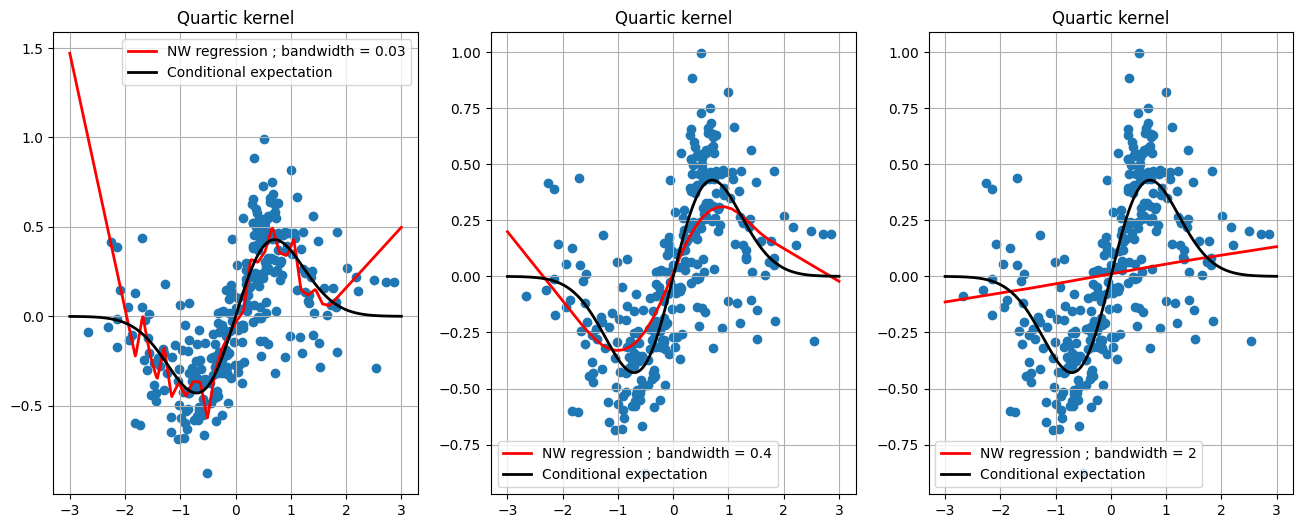

In [284]:
bw = [0.03, 0.4, 2]

fig, axs = plt.subplots(1,3)
fig.set_figwidth(16)
fig.set_figheight(6)
for idx, ax in enumerate(axs):
    y_points = NW_regression(x_points, X, Y, gaussian_kernel, bw[idx])
    p = interp1d(x_points, y_points, kind='linear', fill_value='extrapolate')

    ax.scatter(X, Y)
    ax.plot(x_pts, p(x_pts), color='red', lw=2, label='NW regression ; bandwidth = {}'.format(bw[idx]))
    ax.plot(x_pts, g(x_pts), color='black', lw=2, label='Conditional expectation')
    ax.set_title('Quartic kernel')
    ax.grid()
    ax.legend()

NW regression is very sensitive to bandwidth. The choice of the Kernel is less important.

#### <a id='toc1_1_2_2_'></a>[SLV calibration](#toc0_)

We take the following parameters:
\begin{align*}
    &T=1\\
    &S_0=100\\
    &\sigma_0=0.15\\
    &Y_0=0\\
    &\rho=-0.5\\
    &\gamma=0.5\\
    &\kappa=1
\end{align*}
<br>
We take $\sigma_{Market} = 15\%$ to simplify the code. Besides, we choose our bandwidth with :
$$
    b = \kappa \sigma_{Market}S_0\sqrt{\max(t_k, 0.15)}N^{-0.2}
$$
where $t_k$ is the $k$-th time of discretization, with time step $\Delta t = 0.01$ and $T=1$.<br>
First we define a function to compute next step in Euler scheme.

In [285]:
def euler_new_step(S, Y, spot_vol, rho, gamma, kappa, lev_function, N, time_spacing):
  Z1, Z2 = np.random.randn(N), np.random.randn(N)
  Y_last, S_last = Y[-1, :], S[-1, :]

  rho_bar = rho * np.sqrt( (2 * (1 - np.exp(-kappa * time_spacing))) / (kappa * time_spacing * (1 + np.exp(-kappa * time_spacing))) )
  new_step_S = S_last * np.exp( -0.5 * spot_vol**2 * np.exp(2 * Y_last) * lev_function**2 * time_spacing + spot_vol * np.exp(Y_last) * lev_function *
                               np.sqrt(time_spacing) * ( np.sqrt(1 - rho_bar**2) * Z1 + rho_bar * Z2 ))

  new_step_Y = np.exp(-kappa * time_spacing) * Y_last + gamma * np.sqrt( (1 - np.exp(-2 * kappa * time_spacing)) / (2 * kappa) ) * Z2

  S = np.append(S, [new_step_S], axis=0)
  Y = np.append(Y, [new_step_Y], axis=0)

  return S, Y

Then, the function to approximate conditional expectation and leverage function.

In [286]:
def leverage_polynomial_computation(S, spot_S, Y, spot_vol, kappa, kernel, k, sigma_loc, N, time_spacing, quantile=0.1):
  Y_last, S_last = Y[-1, :], S[-1, :]

  bandwidth = kappa * sigma_loc * spot_S * np.sqrt(np.maximum(k * time_spacing, 0.15)) * N**(-0.2)
  knots = np.linspace(np.percentile(S_last, quantile), np.percentile(S_last, 100 - quantile), 30)

  a_t = spot_vol * np.exp(Y_last)
  a_t_sqr = a_t**2
  a_t_sqr_knots = NW_regression(knots, S_last, a_t_sqr, kernel, bandwidth)

  leverage_knots = sigma_loc / np.sqrt(a_t_sqr_knots)

  return np.poly1d(np.polyfit(knots, leverage_knots, deg=5))

Lastly, we implement particle method for calibration.

In [287]:
def particles_simulation(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, sigma_mkt=0.15, N=10000, time_spacing=0.01):
  S, Y = np.ones((1, N)), np.ones((1, N))
  S *= spot_S
  Y *= spot_Y

  for k in range(int(maturity / time_spacing)):
    leverage_poly = leverage_polynomial_computation(S, spot_S, Y, spot_vol, kappa, quartic_kernel, k, sigma_mkt, N, time_spacing)
    leverage = leverage_poly(S[-1, :])

    S, Y = euler_new_step(S, Y, spot_vol, rho, gamma, kappa, leverage, N, time_spacing)

  return S

We now back-test our calibration method for different strike prices, with Black-Scholes inversion.

In [288]:
spot_S = 100
spot_Y = 0

spot_vol = 0.15
maturity = 1

kappa = 1
gamma = 0.5
rho = -0.5

In [289]:
def call_payoff_scalar(S, K):
  return np.maximum(S - K, 0)

call_payoff = np.vectorize(call_payoff_scalar)
strikes = [80, 90, 100, 110, 120, 130, 140]

S_paths = particles_simulation(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, sigma_mkt=0.15, N=100000)
payoffs = [call_payoff(S_paths[-1, :], K) for K in strikes]
call_values = [np.mean(el) for el in payoffs]

In [290]:
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

In [291]:
imp_vol = []
for K, val in zip(strikes, call_values):
  imp_vol.append(blackscholes_impv_scalar(K, 1, 100, val))

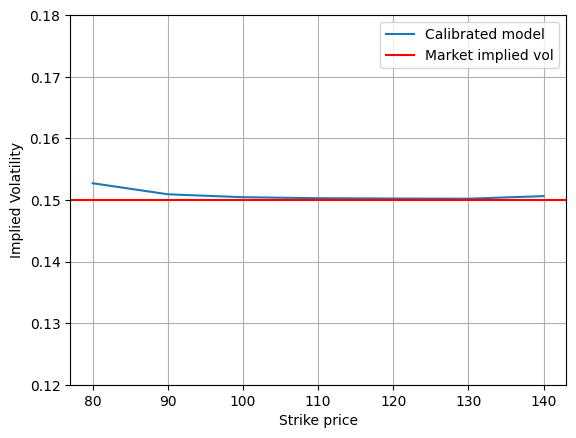

In [292]:
# Plot des implied vol du modèle calibré contre celle du marché
plt.plot(strikes, imp_vol, label="Calibrated model")
plt.axhline(y=0.15, color='red', label="Market implied vol")
plt.xlabel("Strike price")
plt.ylabel("Implied Volatility")
plt.ylim(0.12, 0.18)
plt.legend()
plt.grid()

#### <a id='toc1_1_2_3_'></a>[Parameters impact](#toc0_)

We now compute leverage function and volatility skew for different values of our parameters.<br>
We first begin with $\gamma$ which is the diffusion term in $Y$. We set $\rho=0$.

In [293]:
rho = 0
gamma_values = [0, 0.25, 0.5, 0.75]

# Small change in particle method so that it returns leverage values
def particles_simulation_with_leverage(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, sigma_mkt=0.15, N=10000, time_spacing=0.01):
  S, Y = np.ones((1, N)), np.ones((1, N))
  S *= spot_S
  Y *= spot_Y
  lev_list = []

  for k in range(int(maturity / time_spacing)):

    leverage_poly = leverage_polynomial_computation(S, spot_S, Y, spot_vol, kappa, quartic_kernel, k, sigma_mkt, N, time_spacing)
    leverage = leverage_poly(S[-1, :])

    lev_list.append(leverage)
    S, Y = euler_new_step(S, Y, spot_vol, rho, gamma, kappa, leverage, N, time_spacing)

  return S, lev_list

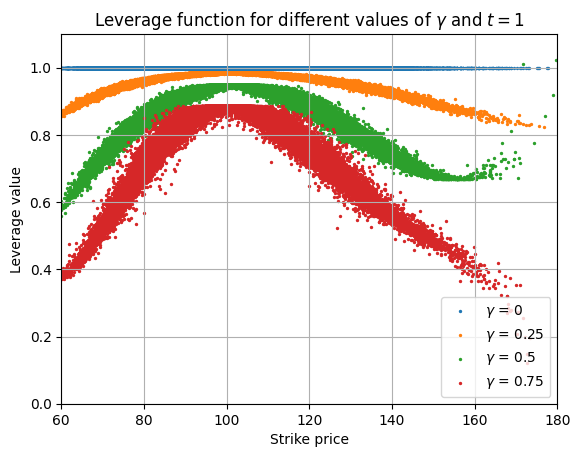

In [294]:
for gamma in gamma_values:
  S, leverages = particles_simulation_with_leverage(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, N=100000)
  plt.scatter(S[-1, :], leverages[-1], label="$\gamma$ = {}".format(gamma), s=2)
plt.ylim(0, 1.1)
plt.xlim(60, 180)
plt.xlabel("Strike price")
plt.ylabel("Leverage value")
plt.title("Leverage function for different values of $\gamma$ and $t=1$")
plt.grid()
plt.legend(loc="lower right")

For $\gamma=0$, it is obvious that leverage is constant : this case indicates a deterministic $Y$ and thus a deterministic stochastic volatility.<br>
Besides, the higher the value of $\gamma$ the more concave the curve.<br>
Now let's have a look on volatility skew in case of pure stochastic volatility ($l(t,S_t)=1$).

In [295]:
# J'adapte la méthode particulaire pour qu'elle utilise l(t, S_t) = 1 pour tout t, S_t (pure stochastic volatility model)
def particles_simulation_pure_stochastic(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, sigma_mkt=0.15, N=10000, time_spacing=0.01):
  S, Y = np.ones((1, N)), np.ones((1, N))
  S *= spot_S
  Y *= spot_Y

  for k in range(int(maturity / time_spacing)):
    S, Y = euler_new_step(S, Y, spot_vol, rho, gamma, kappa, 1.0, N, time_spacing)
  return S

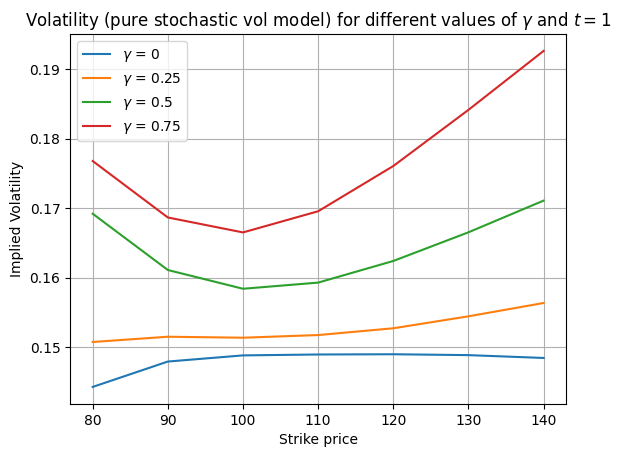

In [296]:
for gamma in gamma_values:
  S = particles_simulation_pure_stochastic(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, N=100000)
  call_values = [np.mean(call_payoff(S[-1, :], K)) for K in strikes]
  impl_vols = [blackscholes_impv_scalar(K, 1, 100, value) for K, value in zip(strikes, call_values)]
  plt.plot(strikes, impl_vols, label="$\gamma$ = {}".format(gamma))
plt.xlabel("Strike price")
plt.ylabel("Implied Volatility")
plt.title("Volatility (pure stochastic vol model) for different values of $\gamma$ and $t=1$")
plt.grid()
plt.legend(loc="upper left")

For $\gamma=0$ we have an almost constant skew.<br>
For larger values of $\gamma$ the smile is more pronouced.<br>
Now let's see the effect of $\rho$. We set $\gamma=0.5$

In [297]:
gamma = 0.5
rho_values = [-0.5, 0, 0.5]

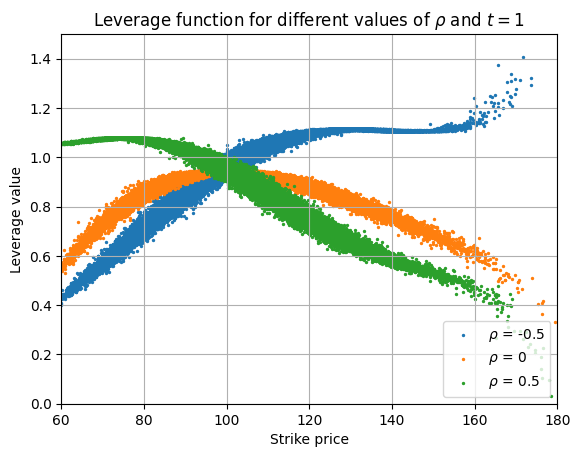

In [298]:
# Leverage values pour différentes valeurs de rho avec les autres paramètres fixés
for rho in rho_values:
  S, leverages = particles_simulation_with_leverage(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, N=100000)
  plt.scatter(S[-1, :], leverages[-1], label=r"$\rho$ = {}".format(rho), s=2)
plt.ylim(0, 1.5)
plt.xlim(60, 180)
plt.xlabel("Strike price")
plt.ylabel("Leverage value")
plt.title(r"Leverage function for different values of $\rho$ and $t=1$")
plt.grid()
plt.legend(loc="lower right")

For $\rho=0$ we almost have a symmetrical curve. The sign of $\rho$ plays a symmetrical role.

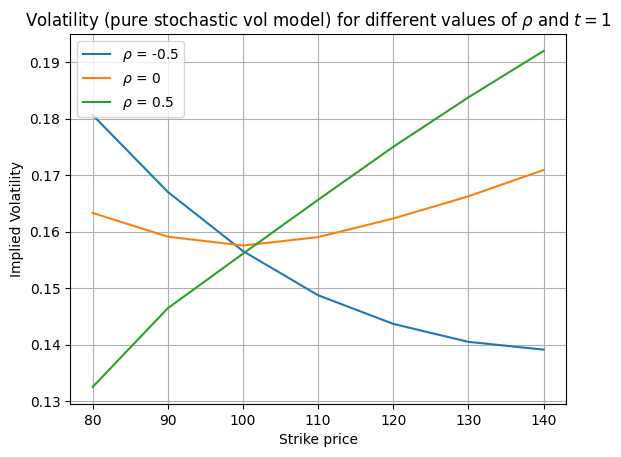

In [299]:
# Implied vol smile pour différentes valeurs de rho avec les autres paramètres fixés, sous pure stochastic volatility model
for rho in rho_values:
  S = particles_simulation_pure_stochastic(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, N=100000)
  call_values = [np.mean(call_payoff(S[-1, :], K)) for K in strikes]
  impl_vols = [blackscholes_impv_scalar(K, 1, 100, value) for K, value in zip(strikes, call_values)]
  plt.plot(strikes, impl_vols, label=r"$\rho$ = {}".format(rho))
plt.xlabel("Strike price")
plt.ylabel("Implied Volatility")
plt.title(r"Volatility (pure stochastic vol model) for different values of $\rho$ and $t=1$")
plt.grid()
plt.legend(loc="upper left")

We have the same effect on skew generated by SV model.<br>
Now we set $\rho = 0$ and see the effect of $\kappa$, the mean reversion speed.

In [300]:
rho = 0
kappa_values = [0.1, 1, 10]

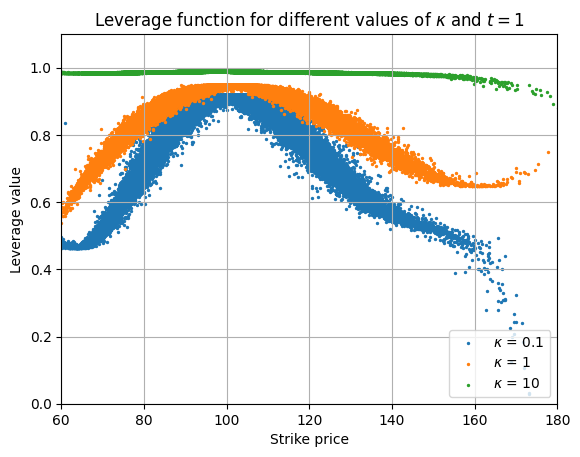

In [301]:
# Leverage values pour différentes valeurs de kappa avec les autres paramètres fixés
for kappa in kappa_values:
  S, leverages = particles_simulation_with_leverage(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, N=100000)
  plt.scatter(S[-1, :], leverages[-1], label=r"$\kappa$ = {}".format(kappa), s=2)
plt.ylim(0, 1.1)
plt.xlim(60, 180)
plt.xlabel("Strike price")
plt.ylabel("Leverage value")
plt.title(r"Leverage function for different values of $\kappa$ and $t=1$")
plt.grid()
plt.legend(loc="lower right")

The smaller the value of $\kappa$ the more pronouced the leverage curve.

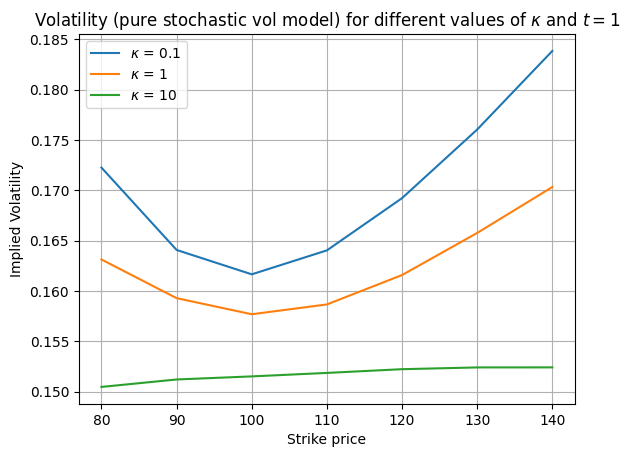

In [302]:
# Implied vol smile pour différentes valeurs de kappa avec les autres paramètres fixés, sous pure stochastic volatility model
for kappa in kappa_values:
  S = particles_simulation_pure_stochastic(spot_S, spot_Y, spot_vol, maturity, rho, gamma, kappa, N=100000)
  call_values = [np.mean(call_payoff(S[-1, :], K)) for K in strikes]
  impl_vols = [blackscholes_impv_scalar(K, 1, 100, value) for K, value in zip(strikes, call_values)]
  plt.plot(strikes, impl_vols, label=r"$\kappa$ = {}".format(kappa))
plt.xlabel("Strike price")
plt.ylabel("Implied Volatility")
plt.title(r"Volatility (pure stochastic vol model) for different values of $\kappa$ and $t=1$")
plt.grid()
plt.legend(loc="upper left")

Small values of $\kappa$ generate more pronounced smiles.